In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn')
sns.set(font_scale=2)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

RESOURCE_PATH = '../../resource'
DATA_PATH = '../../data/data_fountain_529_senta'

### 读取数据

In [2]:
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_data_public.csv'), engine='python')
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_public.csv'), engine='python')

#### 训练集数据

In [3]:
df_train.head()

,id,text,BIO_anno,class
0,0,交行14年用过，半年准备提额，却直接被降到1Ｋ，半年期间只T过一次三千，其它全部真实消费，第...,B-BANK I-BANK O O O O O O O O O O B-COMMENTS_N...,0
1,1,单标我有了，最近visa双标返现活动好,B-PRODUCT I-PRODUCT O O O O O O B-PRODUCT I-PR...,1
2,2,建设银行提额很慢的……,B-BANK I-BANK I-BANK I-BANK B-COMMENTS_N I-COM...,0
3,3,我的怎么显示0.25费率，而且不管分多少期都一样费率，可惜只有69k,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
4,4,利率不错，可以撸,B-COMMENTS_N I-COMMENTS_N B-COMMENTS_ADJ I-COM...,1


In [4]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7528 entries, 0 to 7527
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7528 non-null   int64 
 1   text      7528 non-null   object
 2   BIO_anno  7528 non-null   object
 3   class     7528 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 2.1 MB


#### 测试集数据

In [5]:
df_test.head()

,id,text
0,0,共享一个额度，没啥必要，四个卡不要年费吗？你这种人头，银行最喜欢，广发是出了名的风控严，套现...
1,1,炸了，就2000.浦发没那么好心，草
2,2,挂了电话自己打过去分期提额可以少分一点的
3,3,比如你首卡10k，二卡也10k，信报上显示邮政总共给你的授信额度是20k
4,4,3000吗，浦发总是这样


In [6]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2883 non-null   int64 
 1   text    2883 non-null   object
dtypes: int64(1), object(1)
memory usage: 377.9 KB


可以看到，训练集和测试集的量级都在 1 万级别左右，这对于一个自然语言处理任务来说，并不算多。

部分潜在的先验知识可能无法从样本集中自动识别出来，需要使用预训练模型或者人工构造特征来弥补。

### 文本的分布

In [7]:
train_text = pd.Series(df_train['text'].tolist()).astype(str)
test_text = pd.Series(df_test['text'].tolist()).astype(str)

#### 字符级别的分布

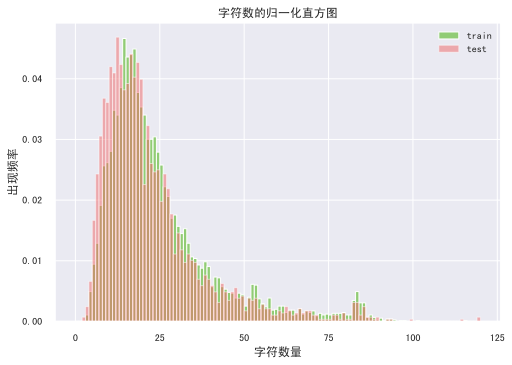

In [8]:
dist_train = train_text.apply(len)
dist_test = test_text.apply(len)

plt.figure()
plt.hist(dist_train, bins=120, range=[0, 120], color='#91CC75', density=True, stacked=True, label='train')
plt.hist(dist_test, bins=120, range=[0, 120], color='#EE6667', density=True, stacked=True, alpha=0.5, label='test')
plt.title('字符数的归一化直方图', fontsize=12)
plt.legend(fontsize=10)
plt.xlabel('字符数量', fontsize=12)
plt.ylabel('出现频率', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

#### 词级别的分布

In [9]:
import jieba

seg_list = jieba.cut("他来到了网易杭研大厦")
list(seg_list)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/lr/4s6k8pc17b9948j2w7tywqxr0000gn/T/jieba.cache
Loading model cost 0.677 seconds.
Prefix dict has been built successfully.


['他', '来到', '了', '网易', '杭研', '大厦']

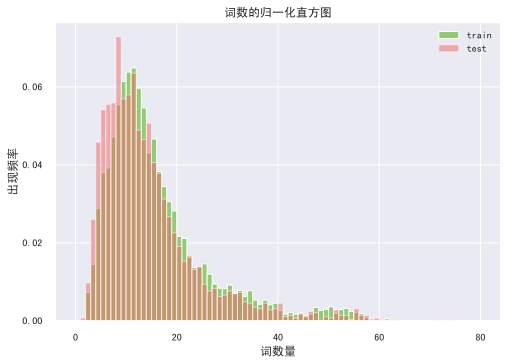

In [10]:
dist_train = train_text.apply(lambda x: len(list(jieba.cut(x))))
dist_test = test_text.apply(lambda x: len(list(jieba.cut(x))))

plt.figure()
plt.hist(dist_train, bins=80, range=[0, 80], color='#91CC75', density=True, stacked=True, label='train')
plt.hist(dist_test, bins=80, range=[0, 80], color='#EE6667', density=True, stacked=True, alpha=0.5, label='test')
plt.title('词数的归一化直方图', fontsize=12)
plt.legend(fontsize=10)
plt.xlabel('词数量', fontsize=12)
plt.ylabel('出现频率', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

通过上面的分析可以基本得到结论，文本长度在训练集与测试集上基本保持分布一致。

**TODO: 找到边界样本，分析文本特征，判断是噪声还是特殊样本。**

### 词云分析

In [11]:
train_words = [word for words in train_text.apply(lambda x: list(jieba.cut(x))) for word in words]
test_words = [word for words in test_text.apply(lambda x: list(jieba.cut(x))) for word in words]

In [12]:
print("train:\t{} {}".format(len(train_words), len(set(train_words))))
print("test:\t{} {}".format(len(test_words), len(set(test_words))))
print("total:\t{} {}".format(len(train_words + test_words), len(set(train_words + test_words))))

train:	119052 9723
test:	40805 5276
total:	159857 11487


In [13]:
def get_stop_words():
    stopwords = set()
    for root, dirs, files in os.walk(os.path.join(RESOURCE_PATH, 'stopwords')):
        for filename in files:
            filepath = os.path.join(root, filename)
            with open(filepath) as f:
                for line in f:
                    stopwords.add(line.strip())
    return list(stopwords)

In [14]:
train_input_text = ' '.join(train_words)
test_input_text = ' '.join(test_words)
total_input_text = ' '.join(train_words + test_words)

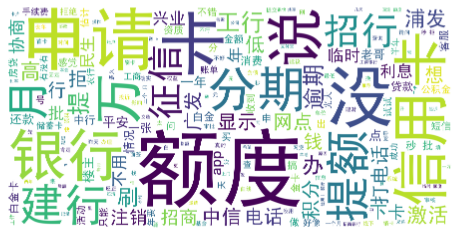

In [15]:
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white',
    scale=32,
    font_path=os.path.join(RESOURCE_PATH, 'font/SimHei.ttf'),
    stopwords=get_stop_words()
)
wc.generate(total_input_text)
plt.axis('off')
plt.imshow(wc)
plt.show()

### 类别的分布

In [16]:
df_train['class'].value_counts() / df_train['class'].count()

2    0.856137
0    0.105606
1    0.038257
Name: class, dtype: float64

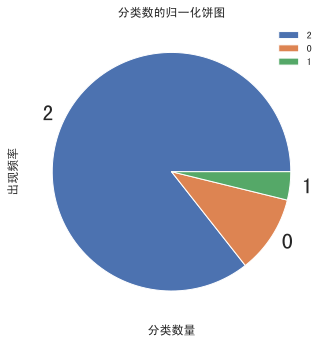

In [17]:
plt.figure()
(df_train['class'].value_counts() / df_train['class'].count()).plot.pie()
plt.title('分类数的归一化饼图', fontsize=12)
plt.legend(fontsize=10)
plt.xlabel('分类数量', fontsize=12)
plt.ylabel('出现频率', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()